In [1]:
import numpy as np  
import numpy.random as random  
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import json
import copy
import statistics as st

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

map = mpimg.imread("map.png") 

# Solving the Travelling Salesman Problem and Modelling the Tacoma Bridge using Python

## Abstract

This report will assess how the well-known 'Travelling Salesman Problem' can be solved as well as how the faulty Tacoma Bridge can be modelled in order to explain its collapse.

A simulated annealing algorithm was used to solve the TSP and it was found that an ideal path can be generated by randomly swapping pairs of cities with a varying probability of rejecting or accepting the swap.

The Tacoma bridge's motion in the wind was explored using numerical methods of solving differential equations, namely by considering the effect of the wind on the bridge's natural frequency.

## Introduction

We will first consider the case of the Travelling Salesman, a well-known example of an optimisation problem. The goal is to find the shortest path between a given number of cities for a travelling salesman to move through, such that no city is visited twice and the salesman returns to his starting point (i.e that the path is a closed loop). A solution to this problem has great application to many areas of modern science and business, many of which pertain to fuel economy by planning optimal routes for delivery drivers and public transport routes. [1] The simulated annealing algorithm was first applied to this problem in 1983 by Kirkpatrick, Gelatt and Vecchi and will form the basis of our solution. [2]

The second situation to be modelled in this report relates to the collapse of the Tacoma Narrows Bridge. The original bridge was opened in July 1940, however it became rapidly apparent that the bridge was of faulty design when it begun swaying in the wind before finally collapsing just four months after its opening.[3] This was found to be the result of aeroelastic flutter, a phenomenon whereby an object's blunt shape within a dynamic fluid generates vortices which cause an oscillatory force to be exerted upon the structure. When this matches the object's natural frequency, a positive feedback is established which can result in the destruction of the object. [4] [5] As a result, it is often cited as an example when discussing the concept of resonance.


## Problem 1 - The Travelling Salesman

As stated previously, simulated annealing will be applied to the TSP in order to solve it for 30 US cities, however a few alternative solutions will now be discussed here.

Applying a brute force strategy by comparing the distance of every single path possible will always succeed in generating the optimal possible path but this is not an applicable solution to this problem. Although this solution is ideal for a smaller number of cities, as the number of cities increases, the number of paths to test becomes impossibly large and the time to run the program grows exponentially. [6]  

The Nearest-Neighbour algorithm decides the next city in the path simply by choosing the city that is closest to the current location. This algorithm is simply implemented and very fast, but does not always return an optimal route and can even in certain instances produce the unique worst possible route. [7]

Instead, we apply the simulated annealing algorithm, which allows a global optimal path to be found probabilistically using many less iterations. A pairwise exchange is performed whereby two cities are swapped in the order and the probability of accepting or rejecting the swap $P$ is generated according to the difference in paths and a parameter we call Temperature $T$:

$$T(t) = \alpha^t T_0$$

$$P = e^{ - \left( d_{new} - d_{old}  \right) / T }$$

The paramater $\alpha$ is a fraction of 1 and acts as the decay constant, causing $T$ to decrease from an original value $T_0$ with each iteration. The probability therefore increases if the new distance is shorter than the old distance but is also dependent on the current magnitude of the parameter $T$. 'Cooling' the temperature ensures we do not fall into a local minimum. This will be discussed in more detail later.

Although SA is a clear alternative to either of the other methods described, it is worth mentioning that it can take a long time to run when many iterations are used as well as the fact that there are many parameters to set. [8]

We now set up our solution by defining various functions.

In [2]:
### UNLOAD CAPITALS FILE INTO LIST ### (Already Provided)

with open('capitals.json', 'r') as capitals_file:
    capitals = json.load(capitals_file)
    
    
capitals_list = list(capitals.items())

capitals_list = [(c[0], tuple(c[1])) for c in capitals_list]




### TAKE COORDINATES FROM CITY NAME ### (Already Provided)

def coord(path):
        """Strip the city name from each element of the path list and return
        a list of tuples containing only pairs of xy coordinates for the
        cities. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> [(585.6, 376.8), ...]
        """
        _, coord = path
        return coord

def coords(path):
        """Strip the city name from each element of the path list and return
        a list of tuples containing only pairs of xy coordinates for the
        cities. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> [(585.6, 376.8), ...]
        """
        _, coords = zip(*path)
        return coords
    
    
    
### PLOT THE PATH ON A MAP OF THE USA ### (modified provided function because input only contains coordinates)

def show_path(path, starting_city, w=35, h=15):
    
    x,y = list(zip(*path))
    x0,y0 = starting_city
    
    plt.imshow(map)
    plt.plot(x0, y0, 'y*', markersize=15)
    plt.plot(x + x[:1], y + y[:1])
    plt.axis('off')
    fig = plt.gcf()
    fig.set_size_inches([w,h])

In [3]:
### DEFINE TEMPERATURE COOLING SCHEDULE ###

def T(t, alpha=0.95, T_0=100000000):
    Temp = (alpha**(t))*T_0
    return Temp

### Generating a Random Start Path

The function to generate a random path to place into our simulated annealing algorithm later on is shown below.

In [4]:
### GENERATE A RANDOM STARTING PATH ###

def randpath(n=8):
    
    a = len(capitals_list)
    
    v = [] # this will be a randomly generated list of integers which correspond to cities in capitals_list
    path = [] # we will fill path with the cities that correspond to the elements in v
    
    while len(v) < n: # keep adding integers to the list until it is of length n
        r = random.randint(0,a) 
        while r in v: # check the city the integer corresponds to is not already in the path
            r = random.randint(0,a)
        v.append(r)
    for i in range(n): # changes each integer in the list to its corresponding city's coordinates
        path.append(coord(capitals_list[v[i]]))
        
    return path # our final result is a list where each element is a pair of coordinates of to a city in capitals_list

Example:

In [5]:
print(randpath())

[(632.4, 364.8), (68.4, 254.0), (204.0, 243.2), (451.6, 186.0), (698.8, 239.6), (489.6, 442.0), (80.0, 139.2), (179.6, 371.2)]


### Performing a Pairwise Exchange

The pairwise exchange refers to swapping two cities in the current order at random. It is important to include a check that the program will not try and swap a city with itself. This would be a wasted iteration, and would detrimentally affect the performance of the simulated annealing algorithm.

In [6]:
### PAIRWISE EXCHANGE ALGORITHM ###

def pairwise(path):
    
    city1 = random.randint(0, len(path)) # not inclusive of len(path), but that's ok because the last number is element len - 1 bc of list indexing
    city2 = random.randint(0, len(path))
    while city1 == city2: # check that the program won't try and swap a city with itself
        city2 = random.randint(0, len(path))
    path[city1], path[city2] = path[city2], path[city1]
    
    return path

Example:

In [7]:
l1 = [1,2,3,4,5,6,7,8,9,10]
print('Before swap:')
print(l1)
print('After swap:')
print(pairwise(l1))

Before swap:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
After swap:
[1, 4, 3, 2, 5, 6, 7, 8, 9, 10]


In [8]:
p1 = randpath()
print(p1)
p1.append(p1[0])
print(p1)

[(698.8, 239.6), (673.2, 293.6), (80.0, 139.2), (702.0, 193.6), (563.6, 216.4), (179.6, 371.2), (204.0, 243.2), (451.6, 186.0)]
[(698.8, 239.6), (673.2, 293.6), (80.0, 139.2), (702.0, 193.6), (563.6, 216.4), (179.6, 371.2), (204.0, 243.2), (451.6, 186.0), (698.8, 239.6)]


### Calculating Total Path Length

We sum the individual paths between consecutive cities as well as the distance between the last and first cities in order to close the loop.

In [9]:
### RETURN THE LENGTH OF A GIVEN PATH ###

# do better
def pathlength(path):
    
    path.append(path[0]) # add the first coordinates to the end of the path to complete the loop
    
    list_of_coordinates = path.append(path[0])
    individual_paths = []
    for i in range(0, len(path)-1):
        x_diff = path[i+1][0] - path[i][0] # pythagoras' theorem was used to find the distances
        y_diff = path[i+1][1] - path[i][1]
        
        distance = np.sqrt(x_diff**2 + y_diff**2)
        individual_paths.append(distance)
    
    total_length = sum(individual_paths) # a list of individual distances was summed to find the total distance
    
    return total_length

Example:

In [10]:
p1 = randpath()
print(pathlength(p1))

1511.5532902591658


In [11]:
### SIMULATED ANNEALING ###

def sim_anneal(start_path, alpha=0.8, n=500):
    
    Temps = []         
    distances = []
    
    for t in range(n):      
        Temp = T(t, alpha, 700) 
        d_start = pathlength(start_path.copy()) # calculating start and new distances and new path
        new_path = pairwise(start_path.copy())
        d_new = pathlength(new_path.copy())
        
        P = np.exp(-(d_new - d_start)/Temp) # probability compares the paths as well as taking T into account
        
        randnum = np.random.uniform(0,1)
        
        Temps.append(Temp)
        distances.append(d_start)
        
        if randnum <= P:     
            start_path = new_path.copy() # if we accept the swap, use the new path the next iteration
        
    final_path = start_path.copy()
    final_distance = pathlength(final_path.copy())
    
    return final_path, final_distance, Temps, distances # all of these returned so analysis can be performed later on


Cooling the temperature is essential to successfully minimising the path length because if the probability of accepting the swap were dependent only on the swap causing a decrease in path length, the minimisation would likely get stuck inside the trough of a local minima, even though a lower global minima may exist elsewhere. 

Provided below is a graph to show how Temperature decreases alongside distance (figure 1) to illustrate how a global minimum is found by requiring that each iteration my re-lengthen the total path even after a local minimum is found. This only occurs at a low number of iterations. Figure 1 shows that a lower $\alpha$ causes Temperature to cool more quickly, thus $\alpha = 0.8$ was found to be the optimal for shortening the path length quickly enough that the algorithm presented an improved solution after 700 iterations, but not so quickly that a local minimum was returned.

C:\Users\holly\AppData\Local\Temp/ipykernel_16980/3584321067.py:14: RuntimeWarning: overflow encountered in exp
  P = np.exp(-(d_new - d_start)/Temp) # probability compares the paths as well as taking T into account


Text(0.15, -0.1, 'Fig 1: A Graph of Temperature as a function of Path Length')

Text(0.5, 0, 'Path Length')

Text(0, 0.5, 'Temperature')

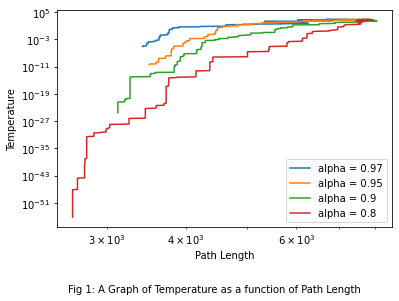

C:\Users\holly\AppData\Local\Temp/ipykernel_16980/3584321067.py:14: RuntimeWarning: overflow encountered in exp
  P = np.exp(-(d_new - d_start)/Temp) # probability compares the paths as well as taking T into account


C:\Users\holly\AppData\Local\Temp/ipykernel_16980/3584321067.py:14: RuntimeWarning: overflow encountered in exp
  P = np.exp(-(d_new - d_start)/Temp) # probability compares the paths as well as taking T into account


C:\Users\holly\AppData\Local\Temp/ipykernel_16980/3584321067.py:14: RuntimeWarning: overflow encountered in exp
  P = np.exp(-(d_new - d_start)/Temp) # probability compares the paths as well as taking T into account


Text(0.15, -0.1, 'Fig 2: A Graph of Path Length against number of iterations t')

Text(0.5, 0, 't')

Text(0, 0.5, 'Path length')

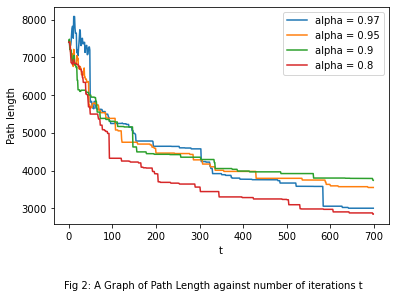

In [12]:
p1 = randpath(30)
for alpha in [0.97,0.95,0.9,0.8]:
    p2, dis, Ts, Ds = sim_anneal(p1, alpha, 600)

    plt.plot(Ds, Ts, label='alpha = '+ str(alpha))

    
plt.figtext(0.15,-0.1,'Fig 1: A Graph of Temperature as a function of Path Length')
plt.xlabel('Path Length')
plt.ylabel('Temperature')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

p1 = randpath(30)

for alpha in [0.97,0.95,0.9,0.8]:
    p2dis = sim_anneal(p1, alpha, 700)[3]
    plt.plot(np.arange(700), p2dis, label='alpha = '+str(alpha))
plt.figtext(0.15,-0.1,'Fig 2: A Graph of Path Length against number of iterations t')
plt.xlabel('t')
plt.ylabel('Path length')
plt.legend()
plt.show()




This implies that, once the annealing has generated a sufficiently small path (after an amount of iterations), it becomes more likely or certain that a swap which decreases the path will be accepted because $P$ will rise above 1. i.e the less optimised the path currently is, the more likely a swap which increases the path length will be accepted, allowing the algorithm to continue searching for the global minima even after having obtained a local minima. It was then investigated how varying the decay parameter $\alpha$ and $T_0$ affected the solution obtained. Smaller $\alpha$ will cause the temperature to decrease more rapidly, making the threshold we start accepting all of the swaps which decrease path length arrive more quickly. This threshold will clearly occur once $T$ dips below 1. For 30 cities, it was found that the optimal parameters were
$\alpha=0.8$, $T_0=1000$. 

It was also investigated how the algorithm performed where $T(t)$ was set to linear and quadratic decay rather than exponential. In the case of quadratic, $T$ did not decrease with temperature as required, and spiked up and down randomly. When the gradient of linear decay was increased, Temperature decreased with distance, but not sufficiently to cause an optimal solution to be obtained. An exponential function is ideal because it does not take any negative values. When $T < 1$, the only swaps guarunteed to happen (i.e for which $P > 1$) would be those that increase path length but there would still be a probability to accept swaps that decrease path length. This makes the function useless because it will not consistently generate a substantially longer or shorter path.

The final solution is now presented by feeding each new path generated by simulated annealing back into the algorithm a total of 20 times. The randomly generated path in figure 3 is given as a comparison to the final solution showed in figure 4.

[]

Text(0.5, 1.0, 'Fig 3: The initial random path')

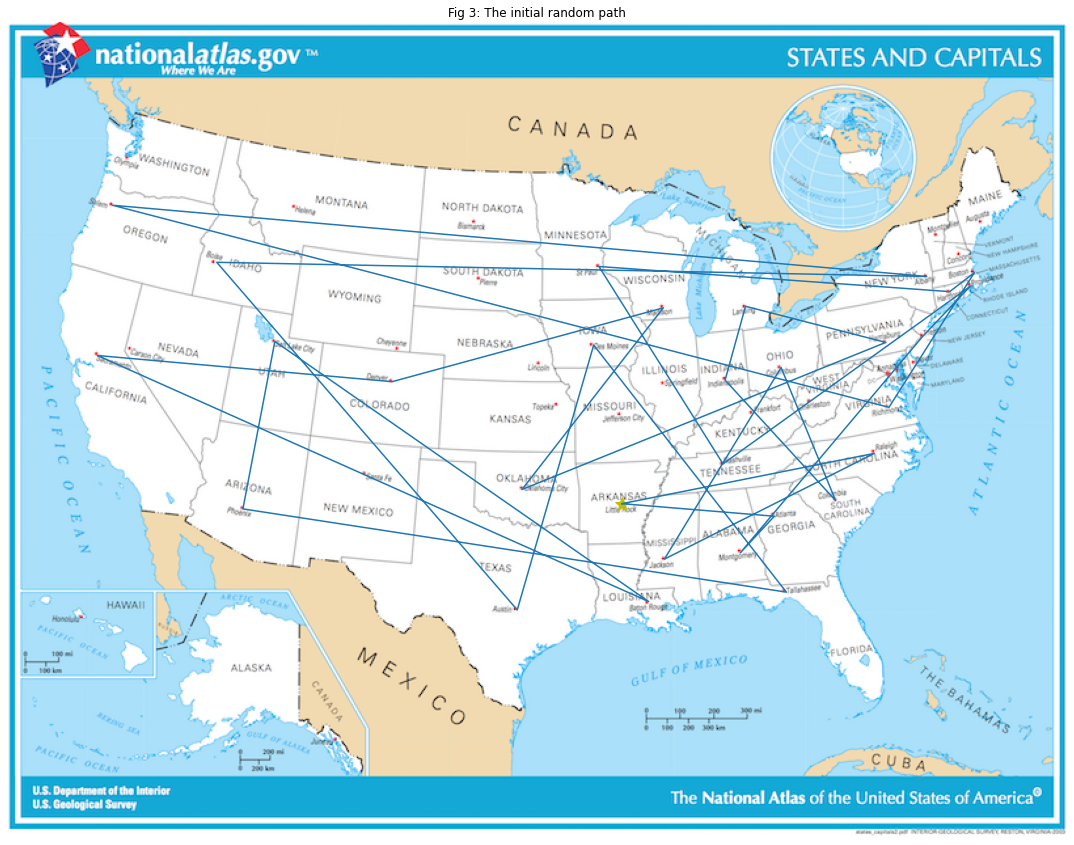

Length of randomly-generated start path: 7057.210553452592


C:\Users\holly\AppData\Local\Temp/ipykernel_16980/3584321067.py:14: RuntimeWarning: overflow encountered in exp
  P = np.exp(-(d_new - d_start)/Temp) # probability compares the paths as well as taking T into account


[]

Text(0.5, 1.0, 'Fig 4: The final optimised path')

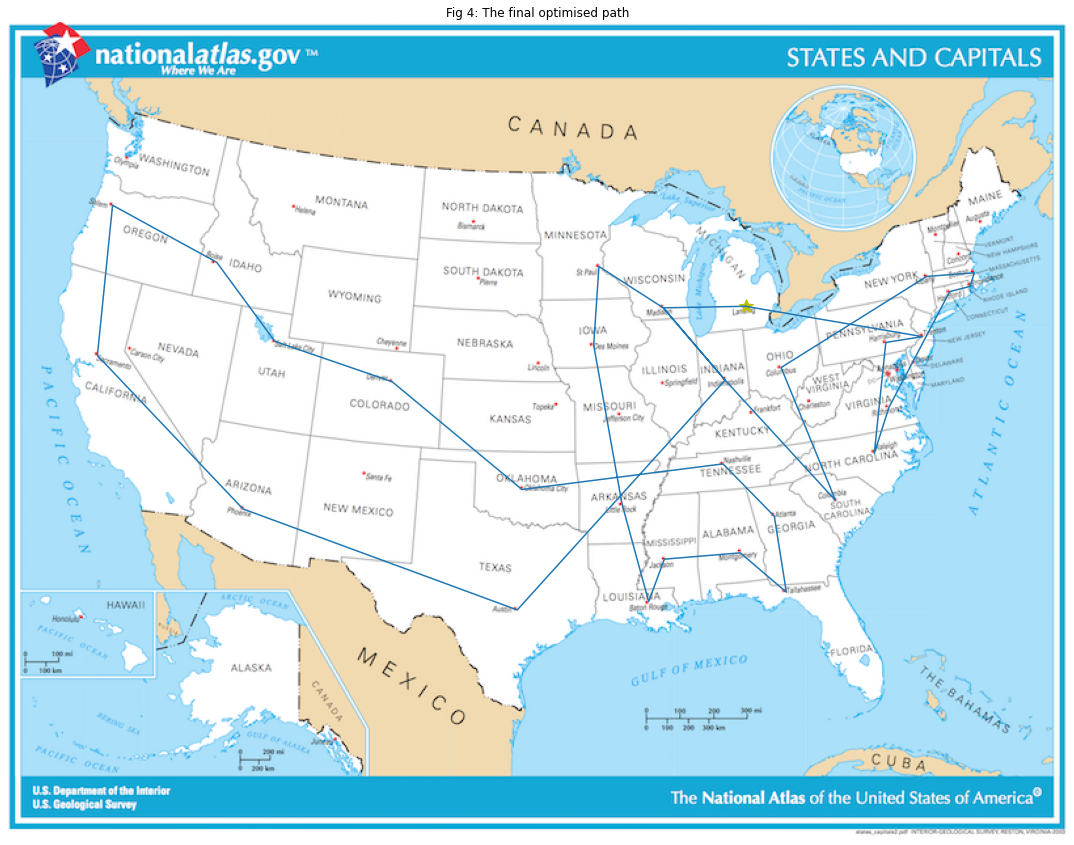

Length of generated optimal path: 2879.248626918852


In [13]:
### FINAL SOLUTION ###

distances = []
paths = []

start_path = randpath(30) # show the original path on map for comparison
plt.plot()
show_path(start_path, start_path[0])
plt.title('Fig 3: The initial random path')
plt.show()
print('Length of randomly-generated start path: ' + str(pathlength(start_path)))

for i in range(20): # the path will be annealed 20 times
    paths.append(start_path.copy())
    distances.append(pathlength(start_path.copy())) # create a list of distances to find a min of later
    new_path = sim_anneal(start_path)[0]
    new_distance = pathlength(new_path)
    start_path = new_path.copy()
        
optimal_distance = min(distances) # search for the minimum distance out of all those found
optimal_path = paths[distances.index(optimal_distance)].copy() # optimal path found from optimal distance

plt.plot()
show_path(optimal_path, optimal_path[0])
plt.title('Fig 4: The final optimised path')
plt.show()

print('Length of generated optimal path: '+ str(optimal_distance))

### Discussion

Simulated annealing was successful in generating an optimised shortened path when presented with a randomised start path with a very large initial total length. The solution is not perfect when viewed with human intuition, but as a probabilistic method with relatively few iterations, this is to be expected. Iterating more times as well as feeding each newly generated path into the algorithm more times would presumably produce the ideal result. The result ranges from roughly 3200-2400 and is less than half of the original path length the vast majority of times. Proving that simulated annealing is a suitable method for solving problems such as these has many implications in areas other than transportation. For example, a simulated annealing algorithm was used in a study investigating the effects of the drug digoxin on the brain. The results of the study found that this drug could be used to treat the most common type of childhood brain tumour, which currently has low survival rates. [9] Furthermore, simulated annealing can also be used to investigate historical biodiversity using data from fossils - this may enable a deeper understanding of human-related influence on present biodiversity. [10]

Cooling $T$ with the optimal decay constant $\alpha$ was imperative - using a larger alpha than 0.8 consistently resulted in a longer final path.

An opposing problem can be considered - how the longest possible path could be found rather than the shortest. The most obvious way to achieve this would be to change the probability of acceptance to the following
$$P = e^{ - \left( d_{old} - d_{new}  \right) / T }$$
where $d_{old}$ and $d_{new}$ have been swapped. This would have the opposite effect to what the algorithm currently does and therefore is a way to achieve the desired outcome.

Another situation to consider is that crossing the country transversally is more difficult in the winter due to snow conditions in central states. To travel along the coastline as much as possible, the map could be centred on an origin $(0,0)$ and the radial distance $r$ from the centre calculated and assigned as a physical parameter to each city. Probability could then be modified as 
$$P = e^{ - \left( d_{new} - d_{old}  \right) / Tr } $$

where the larger the radial distance $r$, (and therefore the further away from the centre of the map), the more likely the swap will be accepted.



## Problem 2 - The Tacoma Narrows Bridge

Here, we apply a numerical method to solve the differential equations associated with the motion of the Tacoma Narrows Bridge and the circumstances which led to its collapse. We begin with two second order differential equations to represent the vertical and torsional oscillations respectively. The motion of the bridge due only to an initial displacement will first be considered, so the wind force is not yet included.

$$z' = y'' = -dy' - (K/Ma)(e^{a(y-lsin(\theta))} + e^{a(y+lsin(\theta))} -2) $$

$$\gamma' = \theta'' = -d\theta' - (3Kcos(\theta)/lMa)(e^{a(y-lsin(\theta))} - e^{a(y+lsin(\theta))}))$$


We must integrate these equations twice each, so to perform the first integration the change of variable $z' = y''$ and $\gamma' = \theta''$ is applied.

A numerical integration is required and Taylor's method was used. The principle is that the integrated function can be incrementally generated by time-stepping over and over until all the new values in the required period have been generated.

$$z[n+1] = z[n] + dt(dz[n]/dt)$$

$$\gamma[n+1] = \gamma[n] + dt(d\gamma[n]/dt)$$

The Cromer method is similar, with the exception of a small modification that we use the next $z'$ and $\gamma'$ in the sequence. We will be comparing the results of both methods.

$$z[n+1] = z[n] + dt(dz[n+1]/dt)$$

$$\gamma[n+1] = \gamma[n] + dt(d\gamma[n+1]/dt)$$

It is therefore possible to integrate the equations in this way, provided some initial conditions are set. In this case, angular displacement is set to a small value initially with all the other parameters being set to 0 at $t=0$.

Some physical parameters related to the bridge are defined here, as well as the algorithm for the bridge when no external wind force is applied. The graphs below show the bridge's torsional and vertical motion for each method and at different initial angular displacement.



In [14]:
tstart=0
tend=100

d=0.01
a=1
M=2500
K=10000
l=6

In [15]:
def tacoma(dt=0.01, cromer=True, theta0=0.01, y0=0, z0=0, gamma0=0):

    # Create the variables to store our results
    times=np.arange(tstart, tend+dt, dt)  # Create the array of model times
    Nt=len(times)                         # Number of time-steps
    y=np.zeros(Nt)                   
    theta=np.zeros(Nt)                   
    z=np.zeros(Nt) 
    gamma=np.zeros(Nt) 

    # Set our initial conditions
    y[0] = y0
    theta[0] = theta0
    z[0] = z0
    gamma[0] = gamma0
    
    # Loop over all of our times and integrate the model
    for n in range(Nt-1):
        exp_minus = np.exp(a*(y[n]-l*np.sin(theta[n])))
        exp_plus = np.exp(a*(y[n]+l*np.sin(theta[n])))
        
        z[n+1] = z[n] + dt*((-d*z[n]) - (K/(M*a))*(exp_minus + exp_plus - 2))
        gamma[n+1] = gamma[n] + dt*((-d*gamma[n]) + ((3*K*np.cos(theta[n]))/(l*M*a))*(exp_minus - exp_plus))
        
        # Time-step the angle. If we are using 'Taylor' or 'Cromer"
        if cromer==True:
            y[n+1] = y[n] + dt*(z[n+1])
            theta[n+1] = theta[n] + dt*(gamma[n+1])
         
        else:
            y[n+1] = y[n] + dt*(z[n])
            theta[n+1] = theta[n] + dt*(gamma[n])

    return times, theta, y

Text(0.5, 0, 'time increments dt = 0.01')

Text(0, 0.5, 'torsional displacement (radians)')

Text(0.15, -0.1, 'Fig 5: Cromer Method For Torsional Displacement when Theta_0 = 0, 0.01, 0.1')

Text(0.5, 1.0, 'Cromer Method')

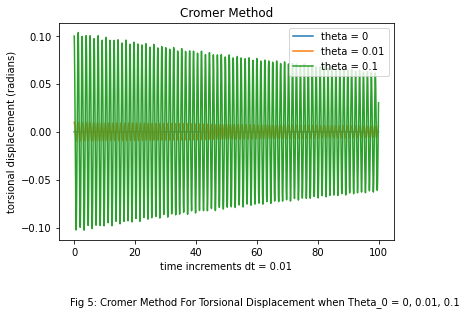

Text(0.5, 0, 'time increments dt = 0.01')

Text(0, 0.5, 'torsional displacement (radians)')

Text(0.15, -0.1, 'Fig 6: Taylor Method For Torsional Displacement when Theta_0 = 0, 0.01, 0.1')

Text(0.5, 1.0, 'Taylor Method')

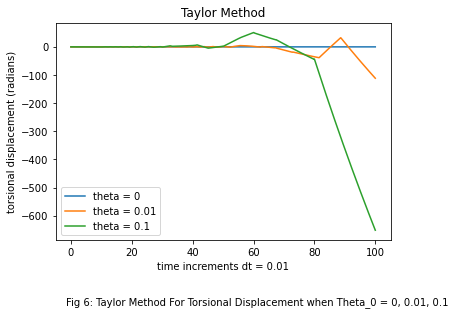

Text(0.5, 0, 'time increments dt = 0.01')

Text(0, 0.5, 'vertical displacement (metres)')

Text(0.15, -0.1, 'Fig 7: Cromer Method For Vertical Displacement when Theta_0 = 0, 0.01, 0.1')

Text(0.5, 1.0, 'Cromer Method')

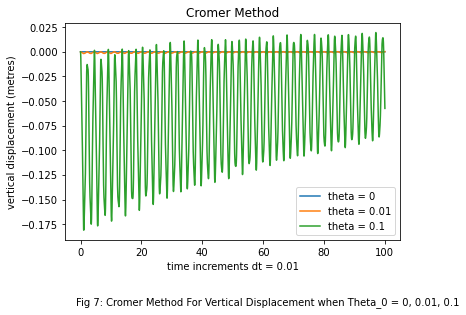

Text(0.5, 0, 'time increments dt = 0.01')

Text(0, 0.5, 'vertical displacement (metres)')

Text(0.15, -0.1, 'Fig 7: Taylor Method For Vertical Displacement when Theta_0 = 0, 0.01, 0.1')

Text(0.5, 1.0, 'Taylor Method')

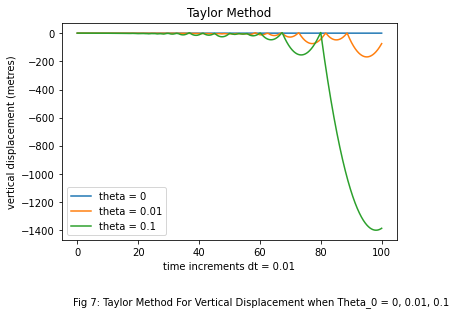

In [16]:
## CROMER METHOD FOR TORSIONAL DISPLACEMENT WHEN THETA_0 = 0, 0.01, 0.1 ##
for i in [0, 0.01, 0.1]:
    times, thetas, ys = tacoma(dt=0.01, cromer=True, theta0=i, y0=0, z0=0, gamma0=0)
    plt.plot(times, thetas, label='theta = '+str(i))
plt.xlabel('time increments dt = 0.01')
plt.ylabel('torsional displacement (radians)')
plt.legend()
plt.figtext(0.15,-0.1,'Fig 5: Cromer Method For Torsional Displacement when Theta_0 = 0, 0.01, 0.1')
plt.title('Cromer Method')
plt.show()


## TAYLOR METHOD FOR TORSIONAL DISPLACEMENT WHEN THETA_0 = 0, 0.01, 0.1 ##
for i in [0, 0.01, 0.1]:
    times, thetas, ys = tacoma(dt=0.01, cromer=False, theta0=i, y0=0, z0=0, gamma0=0)
    plt.plot(times, thetas, label='theta = '+str(i))
plt.xlabel('time increments dt = 0.01')
plt.ylabel('torsional displacement (radians)')
plt.legend()
plt.figtext(0.15,-0.1,'Fig 6: Taylor Method For Torsional Displacement when Theta_0 = 0, 0.01, 0.1')
plt.title('Taylor Method')
plt.show()


## CROMER METHOD FOR VERTICAL DISPLACEMENT WHEN THETA_0 = 0, 0.01, 0.1 ##
for i in [0, 0.01, 0.1]:
    times, thetas, ys = tacoma(dt=0.01, cromer=True, theta0=i, y0=0, z0=0, gamma0=0)
    plt.plot(times, ys, label='theta = '+str(i))
plt.xlabel('time increments dt = 0.01')
plt.ylabel('vertical displacement (metres)')
plt.legend()
plt.figtext(0.15,-0.1,'Fig 7: Cromer Method For Vertical Displacement when Theta_0 = 0, 0.01, 0.1')
plt.title('Cromer Method')
plt.show()


## TAYLOR METHOD FOR VERTICAL DISPLACEMENT WHEN THETA_0 = 0, 0.01, 0.1 ##
for i in [0, 0.01, 0.1]:
    times, thetas, ys = tacoma(dt=0.01, cromer=False, theta0=i, y0=0, z0=0, gamma0=0)
    plt.plot(times, ys, label='theta = '+str(i))
plt.xlabel('time increments dt = 0.01')
plt.ylabel('vertical displacement (metres)')
plt.legend()
plt.figtext(0.15,-0.1,'Fig 7: Taylor Method For Vertical Displacement when Theta_0 = 0, 0.01, 0.1')
plt.title('Taylor Method')
plt.show()



Clearly, the Cromer method is the more realistic representation of the bridge's torsional and vertical oscillations. Under the absence of external force, we expect the amplitude to decrease over time until the bridge settles back into rest, which the Cromer method clearly shows. The Taylor method shows the displacement increasing over time before breaking entirely, but does show oscillatory motion until 20 time increments. The reason for this is that Cromer's method provides a small modification where the current change in variable with respect to time is considered rather than the previous, whereas in Taylor's case, the errors accumulate causing the model to stray further from the real situation. When a smaller dt is used, the difference between the $n^{th}$ and $(n+1)^{th}$ differentials is smaller, and consequently the Taylor method begins to mimic the Cromer method the smaller the $dt$ which is used.

The force provided by the wind is now modelled by a sinusoidal force $F(t)$.

$$ F(t) = A \sin( \omega t )$$

Which, under the conditions for forced harmonic motion, is added to $y''$

$$y'' = z ' = -dy' - (K/Ma)(e^{a(y-lsin(\theta))} + e^{a(y+lsin(\theta))} -2) + Asin(\omega t)$$

In [17]:
def tacoma_wind(dt=0.01, omega=3, A=1, cromer=True, theta0=0.01, y0=0, z0=0, gamma0=0):

    # Create the variables to store our results
    times=np.arange(tstart, tend+dt, dt)  # Create the array of model times
    Nt=len(times)                         # Number of time-steps
    y=np.zeros(Nt)                   
    theta=np.zeros(Nt)                   
    z=np.zeros(Nt) 
    gamma=np.zeros(Nt) 

    # Set our initial conditions
    y[0] = y0
    theta[0] = theta0
    z[0] = z0
    gamma[0] = gamma0
    
    # Loop over all of our times and integrate the model
    for n in range(Nt-1):
        exp_minus = np.exp(a*(y[n]-l*np.sin(theta[n])))
        exp_plus = np.exp(a*(y[n]+l*np.sin(theta[n])))
        
        
        # time step derivatives of position and angle
        z[n+1] = z[n] + dt * (-d * (z[n]) - (K/(M*a)) * (exp_minus + exp_plus -2) + A * np.sin(omega * times[n]))  # force added
        gamma[n+1] = gamma[n] + dt * (-d * (gamma[n]) + (3 * np.cos(theta[n])/l * (K/(M*a)) *(exp_minus - exp_plus)))
        
        # Time-step the position and angle whether we are using 'Taylor' or 'Cromer"
        if cromer==True:
            y[n+1] = y[n] + dt*(z[n+1])
            theta[n+1] = theta[n] + dt*(gamma[n+1])
         
        else:
            y[n+1] = y[n] + dt*(z[n])
            theta[n+1] = theta[n] + dt*(gamma[n])

    return times, theta, y


Figures 8-11 show the effect on the torsional and vertical motion of varying the amplitude of the wind force for both methods.


Text(0.15, -0.1, 'Fig 8: Cromer Method For Torsional Displacement under wind force with angular frequency 3')

Text(0.5, 0, 'time increments dt')

Text(0, 0.5, 'torsional displacement (radians)')

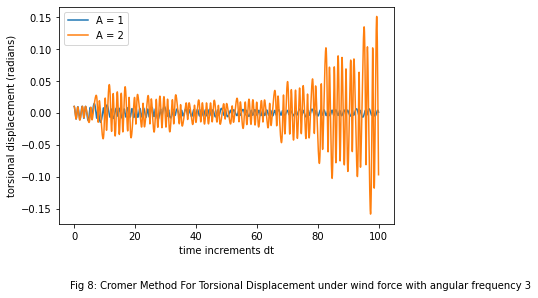

Text(0.15, -0.1, 'Fig 9: Taylor Method For Torsional Displacement under wind force with angular frequency 3')

Text(0.5, 0, 'time increments dt')

Text(0, 0.5, 'torsional displacement (radians)')

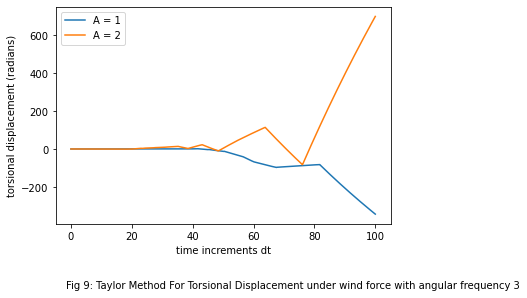

Text(0.15, -0.1, 'Fig 10: Cromer Method For Vertical Displacement under wind force with angular frequency 3')

Text(0.5, 0, 'time increments dt')

Text(0, 0.5, 'Verical displacement')

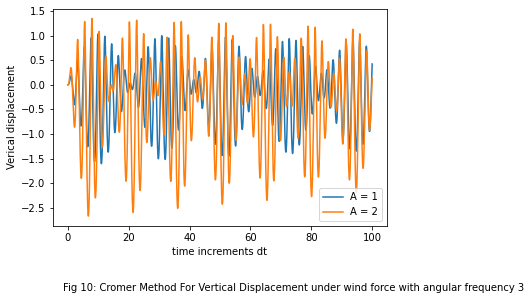

Text(0.15, -0.1, 'Fig 11: Taylor Method For Vertical Displacement under wind force with angular frequency 3')

Text(0.5, 0, 'time increments dt')

Text(0, 0.5, 'Verical displacement')

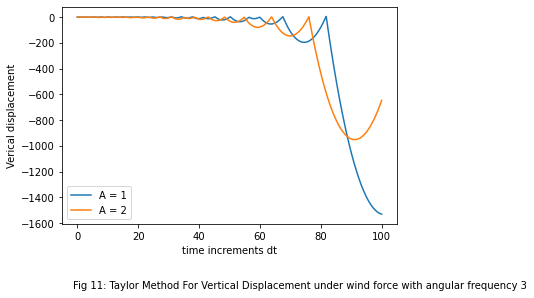

In [18]:
for i in [1,2]:
    times, thetas, ys = tacoma_wind(dt=0.01, omega=3, A=i, cromer=True, theta0=0.01, y0=0, z0=0, gamma0=0)
    plt.plot(times, thetas, label='A = '+str(i))
plt.figtext(0.15,-0.1,'Fig 8: Cromer Method For Torsional Displacement under wind force with angular frequency 3')
plt.xlabel('time increments dt')
plt.ylabel('torsional displacement (radians)')
plt.legend()
plt.show()

for i in [1,2]:
    times, thetas, ys = tacoma_wind(dt=0.01, omega=3, A=i, cromer=False, theta0=0.01, y0=0, z0=0, gamma0=0)
    plt.plot(times, thetas, label='A = '+str(i))
plt.figtext(0.15,-0.1,'Fig 9: Taylor Method For Torsional Displacement under wind force with angular frequency 3')
plt.xlabel('time increments dt')
plt.ylabel('torsional displacement (radians)')
plt.legend()
plt.show()



for i in [1,2]:
    times, thetas, ys = tacoma_wind(dt=0.01, omega=3, A=i, cromer=True, theta0=0.01, y0=0, z0=0, gamma0=0)
    plt.plot(times, ys, label='A = '+str(i))
plt.figtext(0.15,-0.1,'Fig 10: Cromer Method For Vertical Displacement under wind force with angular frequency 3')
plt.xlabel('time increments dt')
plt.ylabel('Verical displacement')
plt.legend()
plt.show()

for i in [1,2]:
    times, thetas, ys = tacoma_wind(dt=0.01, omega=3, A=i, cromer=False, theta0=0.01, y0=0, z0=0, gamma0=0)
    plt.plot(times, ys, label='A = '+str(i))
plt.figtext(0.15,-0.1,'Fig 11: Taylor Method For Vertical Displacement under wind force with angular frequency 3')
plt.xlabel('time increments dt')
plt.ylabel('Verical displacement')
plt.legend()
plt.show()






It would be useful to know the resonant frequency of the Tacoma bridge in order to estimate at what point the bridge is likely to be under the most strain. In order to find the this value, the root mean square of vertical and torsional displacement were found for many different values of $\omega$ between 2 and 4 using the Cromer method of numerical integration, which has been previously shown to be the more realistic model. The value which gives the largest displacement is most likely the resonant frequency, and figure 12 shows that the same value is found when considering either torsional or vertical displacement.

Text(0.15, -0.1, 'Fig 12: rms displacement as a function of omega for vertical and torsional modes')

Text(0.5, 0, 'rms displacement')

Text(0, 0.5, 'angular frequency omega')

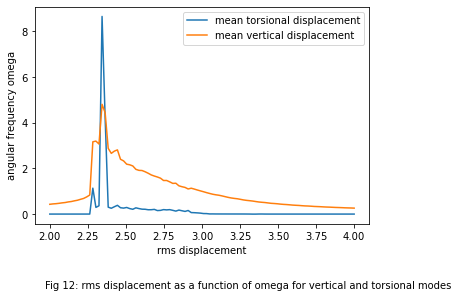

In [19]:
rangeomega = np.linspace(2, 4, 100)

tdp = []
vdp = []


for om in rangeomega:
    times, thetas, ys = tacoma_wind(dt=0.01, omega=om, A=2, cromer=True, theta0=0.01, y0=0, z0=0, gamma0=0)
    sqys = ys**2
    sqthetas = thetas**2
    torsdp = np.sqrt(np.mean(sqthetas))
    tdp.append(torsdp)
    vertdp = np.sqrt(np.mean(sqys))
    vdp.append(vertdp)


plt.plot(rangeomega, tdp, label='mean torsional displacement')
plt.plot(rangeomega, vdp, label='mean vertical displacement')
plt.figtext(0.15,-0.1,'Fig 12: rms displacement as a function of omega for vertical and torsional modes')
plt.xlabel('rms displacement')
plt.ylabel('angular frequency omega')
plt.legend()
plt.show()




In [20]:
maxvdp = max(vdp) # find the maximum displacement
maxvdpindex = vdp.index(maxvdp) # the index of this will be the same as the index of the resonant omega
vresfreq = rangeomega[maxvdpindex]
print('The resonant frequency which produces the greatest mean vertical displacement it ' +str(vresfreq))

maxtdp = max(tdp)
maxtdpindex = tdp.index(maxtdp)
tresfreq = rangeomega[maxtdpindex]
print('The resonant frequency which produces the greatest mean vertical displacement it ' +str(tresfreq))


The resonant frequency which produces the greatest mean vertical displacement it 2.3434343434343434
The resonant frequency which produces the greatest mean vertical displacement it 2.3434343434343434


The Tacoma bridge's collapse was most likely due to the sudden change from vertical to torsional oscillation [11] so investigated in figure 13 is the time trajectories for $\theta(t)$ and $y(t)$ for a few different values of $\omega$ The more diagonal the curve, the more both are happening at once. In particular, note the curve for the resonant frequency in comparison to its neighbours, given here to be 2.3. The motion is chaotic, with minute changes in the initial conditions affecting the motion greatly.

Text(0.5, 1.0, 'A=2, Cromer')

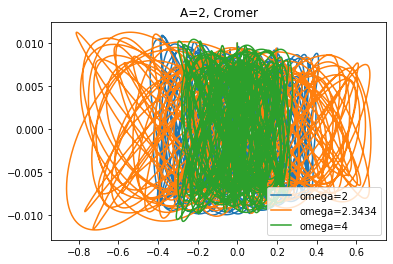

In [21]:
for o in [2,2.3434,4]:
    times, thetas, ys = tacoma_wind(dt=0.01, omega=o, A=1, cromer=True, theta0=0.01, y0=0, z0=0, gamma0=0)
    plt.plot(ys, thetas, label='omega='+str(o))
plt.legend()
plt.title('A=2, Cromer')
plt.show()

### Discussion

The motion of the Tacoma bridge both with and without the wind's effect was modelled by solving the 2nd order differential equations associated with its torsional and vertical oscillations. Its root-mean-square vertical and torsional displacements were each independently then used to find the resonant frequency of the bridge, which was found to be 2.34 in both cases, which implies the correct value was found. When the periodic force exerted by the wind matches this frequency, the bridge is likely to experience the most strain and therefore most likely to break.

A similar instance where resonant forces caused a bridge to collapse occured in 1831, where the marching of a group of soldiers as they crossed the Broughton Suspension Bridge in England acted in a similar manner to the wind in the case of the Tacoma bridge. As a result, soldiers are instructed to break stride when crossing bridges because their combined force can match the natural frequency of the bridge and cause it to destabilise. [12]

After the Tacoma Narrows collapse, it was found after investigation that a structural change which allowed the wind to flow through the sides of the bridge rather than catch on it in a similar manner to a sail and cause it to sway. [5] This failure caused much attention to be turned to the study of aerodynamic effects in solid structures and still greatly influences the design of bridges today.


## Conclusion

In this report, two problems were examined - those of the travelling salesman and the Tacoma Narrows bridge. A simulated annealing algorithm was used to find an optimal path between 30 US cities. The operation was successful as the path found was greatly smaller than the original random path generated between the 30 cities. The Tacoma Narrows Bridge was modelled using 2nd order differential equations which both the Taylor or Cromer methods were used to solve numerically by generating a list of $y$ and $\theta$ values and plotting them against small time increments $dt$. The resonant frequency was also found by comparing the root-mean-square displacement vertically to torsionally and taking the assumption that the resonant frequency is that which causes the largest average displacement in both cases. This value was found to be 2.34. 

These results are significant because they mimic the work of real life engineers and numerical modellers who apply techniques like these to solve problems, for example providing delivery companies with algorithms to calculate ideal routes for multiple deliveries in an area. Numerical methods of integration are implemented when computers are needed to calculate many results and it is not possible to apply analytical integration. These skills are paramount in a scientific sphere which relies further and further upon computers to solve problems.

Future work that could be conducted includes timetable optimisation and how the physical layout of computer chips can be optimised so that interference between different parts is minimised. [13] Further optimising these algorithms includes experimental calculation of the ideal parameters to be used in the simulated annealing algorithm, in particular, $\alpha$, to ensure the optimal cooling schedule is established. Accurate physical measurements must also be taken of real life situations to be modelled by ODEs in order to ensure the most accurate model is produced. 


## Bibliography


[1] 	S. Ma, "Solving The Travelling Salesman Problem (TSP) For Deliveries," Routifc, 2 January 2020. [Online]. Available: https://blog.routific.com/travelling-salesman-problem. [Accessed 18 January 2022].

[2] 	S. Kirkpatrick, C. D. Gelatt and M. P. Vecchi, "Optimization by Simulated Annealing," Science, vol. 220, no. 4598, pp. 671-680, 1983. 

[3] 	"History of the Tacoma Narrows Bridge," University of Washington, [Online]. Available: https://www.lib.washington.edu/specialcollections/collections/exhibits/tnb/bibliography. [Accessed 18 January 2022].

[4] 	Warsaw University of Technology Team, "SAE Aero Design 2007 - Flutter," 29 May 2007. [Online]. Available: https://www.youtube.com/watch?v=nRit6tcNT4s. [Accessed 18 January 2022].

[5] 	K. Yusuf Billah and R. H. Scanlan, "Resonance, Tacoma Narrows Bridge Failure, and Undergraduate Physics Textbooks," 1990.

[6] 	"Brute Force Approach and its pros and cons," GeeksforGeeks, 4 May 2021. [Online]. Available: https://www.geeksforgeeks.org/brute-force-approach-and-its-pros-and-cons/. [Accessed 18 January 2021].

[7] 	J. Bang-Jensen, G. Gutin and A. Yeo, "When the greedy algorithm fails," ScienceDirect, vol. 1, no. 2, pp. 121-127, 2004.

[8] 	F. Liang, "Optimization Techniques — Simulated Annealing," Towards Data Science, 21 April 2020. [Online]. Available: https://towardsdatascience.com/optimization-techniques-simulated-annealing-d6a4785a1de7#:~:text=Simulated%20Annealing.%20Simulated%20Annealing%20%28SA%29%20mimics%20the%20Physical,Example%20of%20a%20problem%20with%20a%20local%20minima.. [Accessed 19 January 2022].

[9] 	L. H. e. al., "Systems biology–based drug repositioning identifies digoxin as a potential therapy for groups 3 and 4 medulloblastoma," Science Translational Medicine, vol. 10, no. 464, 2018. 

[10] 	J.-X. F. e. al., "A high-resolution summary of Cambrian to Early Triassic marine invertebrate biodiversity," Science, vol. 367, no. 6475, pp. 272-277, 2020. 

[11] 	G. Arioli and F. Gazzola, "Old and new explanations of the Tacoma Narrows Bridge collapse," Torino, p. 10, 2013. 

[12] 	G. Wu, "Modeling Bridge Oscillations Induced by Marching Soldiers," International Journal of Mathemetics and its Applications, vol. 8, no. 4, pp. 95-101, 2020. 

[13] 	Z. Varty, Simulated Annealing Overview, 2018. 



